In [31]:
import pandas as pd
import pycountry
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
import geopandas as gpd
import geodatasets
from scipy.stats import zscore
import statsmodels.api as sm

In [2]:
# Extracted file from kaggle
data = pd.read_csv("weather_data/GlobalWeatherRepository.csv", parse_dates=["last_updated"], index_col="last_updated")

print(data.columns)

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'temperature_celsius', 'temperature_fahrenheit',
       'condition_text', 'wind_mph', 'wind_kph', 'wind_degree',
       'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm',
       'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')


Data Cleaning & Preprocessing

In [3]:
categorical_cols = ['country', 'location_name', 'timezone', 'condition_text', 'wind_direction']
numeric_cols = data.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Encode categorical columns separately
for col in categorical_cols:
    label_encoder = LabelEncoder()
    data[col + "_encoded"] = label_encoder.fit_transform(data[col])

# Add encoded categorical columns to numeric columns list
encoded_cols = [col + "_encoded" for col in categorical_cols]
numeric_cols.extend(encoded_cols)

# Handle missing values with interpolation (only for numeric columns)
data[numeric_cols] = data[numeric_cols].interpolate()

# Handle outliers using z-score method (only on numeric columns)
data_clean = data[(np.abs(zscore(data[numeric_cols])) < 3).all(axis=1)]

# Normalize numeric data for LSTM/GRU
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_clean[numeric_cols]), 
                           columns=numeric_cols, index=data_clean.index)

print(data.columns)

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'temperature_celsius', 'temperature_fahrenheit',
       'condition_text', 'wind_mph', 'wind_kph', 'wind_degree',
       'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm',
       'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination',
       'country_encoded', 'location_name_encoded', 'timezone_encoded',
       'condition_text_encoded', 'wind_direction_encoded'],
      dtype='object')


Exploratory Data Analysis (EDA)

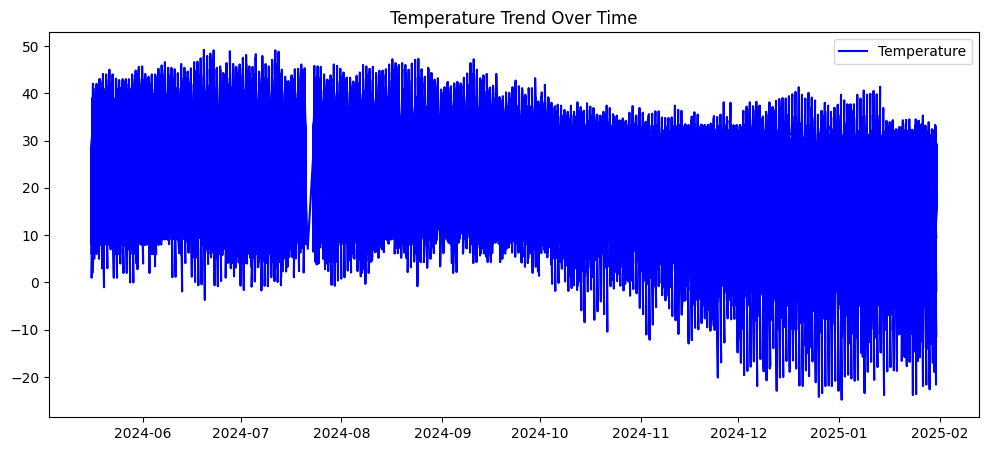

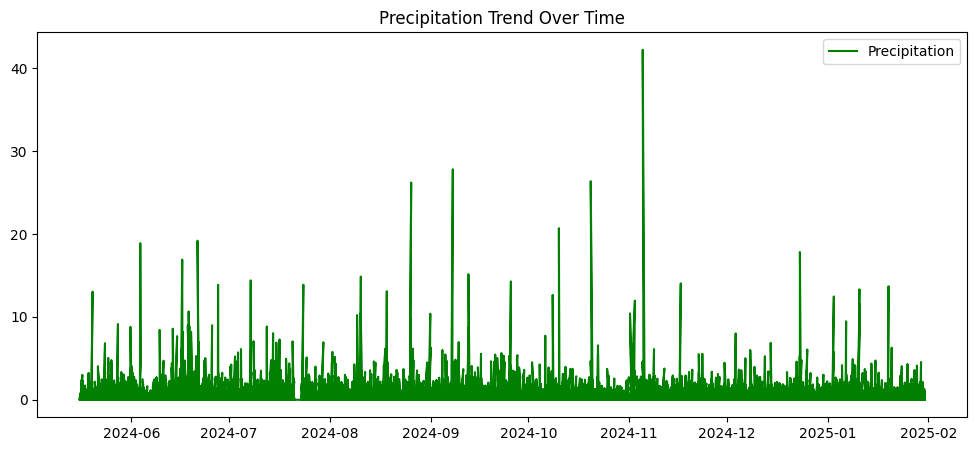

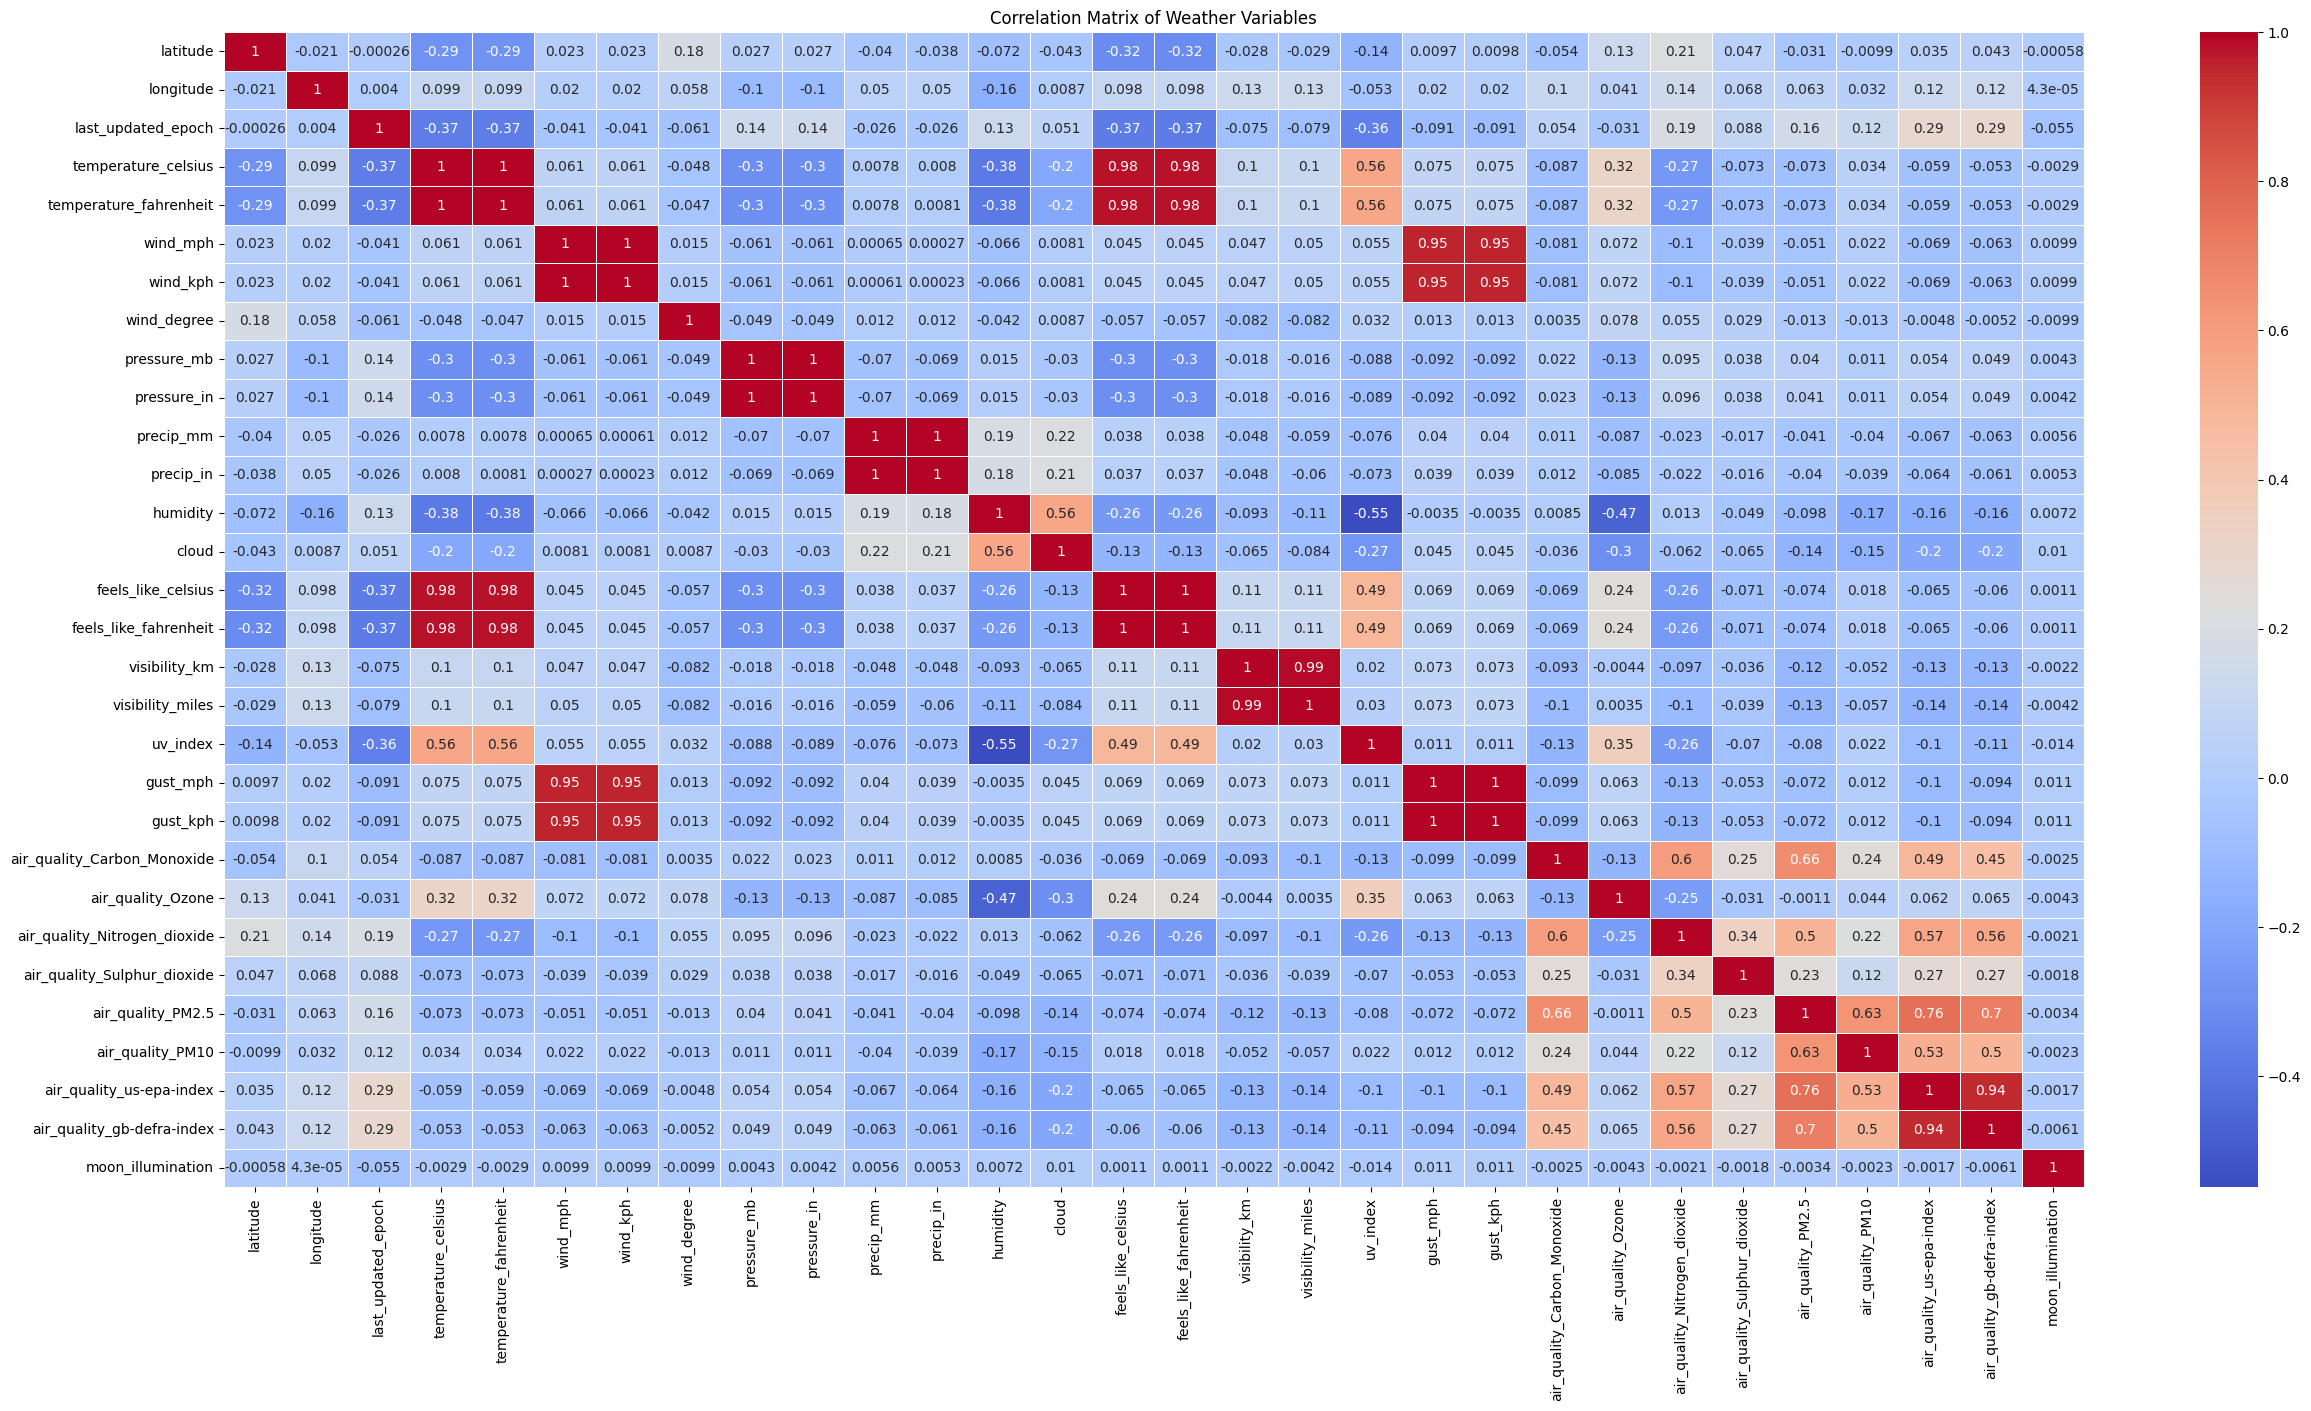

In [4]:
# Plot temperature trends
plt.figure(figsize=(12,5))
plt.plot(data.index, data["temperature_celsius"], label="Temperature", color="blue")
plt.legend()
plt.title("Temperature Trend Over Time")
plt.show()

# Plot precipitation trends
plt.figure(figsize=(12,5))
plt.plot(data.index, data["precip_mm"], label="Precipitation", color="green")
plt.legend()
plt.title("Precipitation Trend Over Time")
plt.show()

numeric_data = data.select_dtypes(include=["float64", "int64"])

# Correlation heatmap
plt.figure(figsize=(30, 15))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Weather Variables")
plt.show()

Model Building

In [5]:
#1st Model - LSTM Model
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i : i + seq_length].values)
        y.append(data.iloc[i + seq_length]["temperature_celsius"])
        
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(data_scaled, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
def build_lstm_model(hp):
    model = Sequential([
        LSTM(hp.Int("units", 32, 128, step=32), return_sequences=True, input_shape=(seq_length, X.shape[2])),
        LSTM(hp.Int("units", 32, 128, step=32), return_sequences=False),
        Dense(hp.Int("dense_units", 16, 64, step=16), activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])), loss="mse")
    
    return model

# Tune LSTM
lstm_tuner = kt.Hyperband(build_lstm_model, objective="val_loss", max_epochs=20, factor=3, directory="lstm_tuning")
lstm_tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]
best_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Reloading Tuner from lstm_tuning\untitled_project\tuner0.json



d:\Python\Python Files\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\Python\Python Files\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0052 - val_loss: 0.0185
Epoch 2/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - loss: 0.0051 - val_loss: 0.0179
Epoch 3/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - loss: 0.0049 - val_loss: 0.0186
Epoch 4/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - loss: 0.0046 - val_loss: 0.0166
Epoch 5/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - loss: 0.0044 - val_loss: 0.0178
Epoch 6/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 48s 43ms/step - loss: 0.0044 - val_loss: 0.0181
Epoch 7/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - loss: 0.0041 - val_loss: 0.0185
Epoch 8/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - loss: 0.0040 - val_loss: 0.0182
Epoch 9/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - loss: 0.0038 - val_loss: 0.0192
Epoch 10/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - loss: 0.0036 - val_loss: 0.0213
Epoch 11/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - loss: 0.0035 - val_loss: 0.0181
Epoch 12

In [6]:
y_pred_lstm = best_lstm_model.predict(X_test)

mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)

print(f"LSTM MSE: {mse_lstm:.4f}")
print(f"LSTM MAE: {mae_lstm:.4f}")
print(f"LSTM RMSE: {rmse_lstm:.4f}")

277/277 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
LSTM MSE: 0.0204
LSTM MAE: 0.0988
LSTM RMSE: 0.1429


In [7]:
#2nd Model - GRU Model
def build_gru_model(hp):
    model = Sequential([
        GRU(hp.Int("units", 32, 128, step=32), return_sequences=True, input_shape=(seq_length, X.shape[2])),
        GRU(hp.Int("units", 32, 128, step=32), return_sequences=False),
        Dense(hp.Int("dense_units", 16, 64, step=16), activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])), loss="mse")
    
    return model

# Tune GRU
gru_tuner = kt.Hyperband(build_gru_model, objective="val_loss", max_epochs=20, factor=3, directory="gru_tuning")
gru_tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)
best_gru_model = gru_tuner.get_best_models(num_models=1)[0]
best_gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Reloading Tuner from gru_tuning\untitled_project\tuner0.json


d:\Python\Python Files\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\Python\Python Files\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - loss: 0.0054 - val_loss: 0.0168
Epoch 2/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - loss: 0.0053 - val_loss: 0.0174
Epoch 3/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 0.0051 - val_loss: 0.0171
Epoch 4/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - loss: 0.0048 - val_loss: 0.0174
Epoch 5/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - loss: 0.0047 - val_loss: 0.0170
Epoch 6/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - loss: 0.0045 - val_loss: 0.0167
Epoch 7/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - loss: 0.0043 - val_loss: 0.0173
Epoch 8/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 0.0041 - val_loss: 0.0182
Epoch 9/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 0.0039 - val_loss: 0.0177
Epoch 10/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - loss: 0.0037 - val_loss: 0.0181
Epoch 11/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - loss: 0.0036 - val_loss: 0.0175
Epoch 12

In [8]:
y_pred_gru = best_gru_model.predict(X_test)

mse_gru = mean_squared_error(y_test, y_pred_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_gru= np.sqrt(mse_lstm)

print(f"GRU MSE: {mse_gru:.4f}")  
print(f"GRU MAE: {mae_gru:.4f}")
print(f"GRU RMSE: {rmse_gru:.4f}")

277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
GRU MSE: 0.0189
GRU MAE: 0.0988
GRU RMSE: 0.1429


Advanced EDA

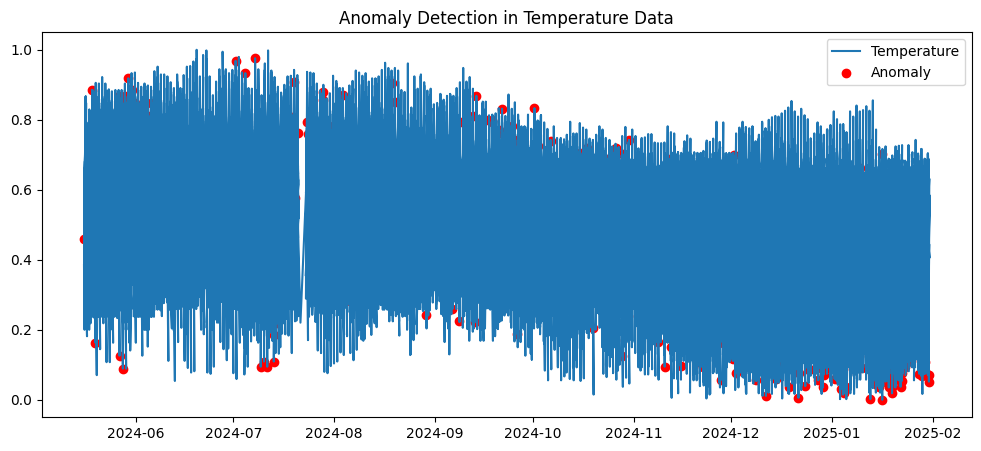

In [10]:
# Anomaly detection
iso_forest = IsolationForest(contamination=0.01)  # Adjust contamination level as needed
data_scaled["anomaly"] = iso_forest.fit_predict(data_scaled)

# Plot anomalies
plt.figure(figsize=(12,5))
plt.plot(data_scaled.index, data_scaled["temperature_celsius"], label="Temperature")
plt.scatter(data_scaled.index[data_scaled["anomaly"] == -1], data_scaled["temperature_celsius"][data_scaled["anomaly"] == -1], color="red", label="Anomaly")
plt.legend()
plt.title("Anomaly Detection in Temperature Data")
plt.show()

Forecasting with Multiple Models

In [9]:
# Ensemble 
y_pred_ensemble = (y_pred_lstm + y_pred_gru) / 2

mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_lstm)

print(f"Ensemble MSE: {mse_ensemble:.4f}")  
print(f"Ensemble MAE: {mae_ensemble:.4f}")
print(f"Ensemble RMSE: {rmse_ensemble:.4f}")

Ensemble MSE: 0.0170
Ensemble MAE: 0.0909
Ensemble RMSE: 0.1429


Climate Analysis

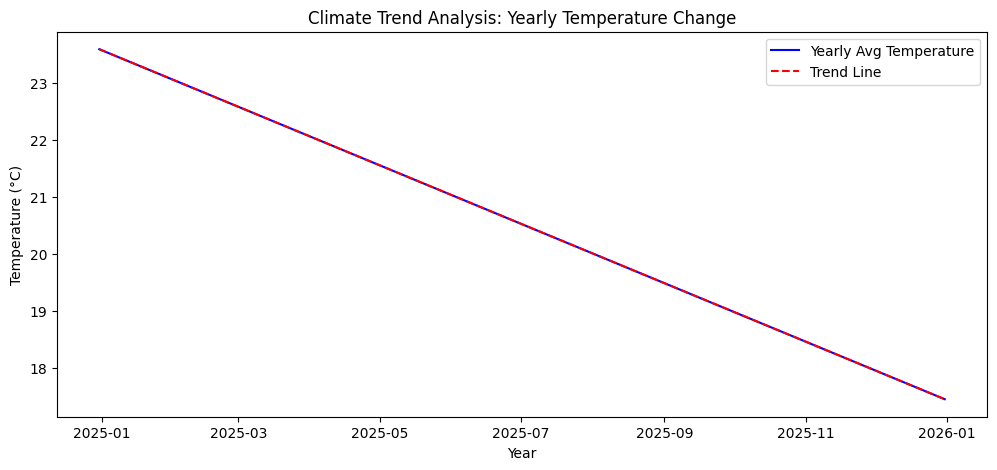

                             OLS Regression Results                            
Dep. Variable:     temperature_celsius   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                    nan
Method:                  Least Squares   F-statistic:                       nan
Date:                 Sat, 01 Feb 2025   Prob (F-statistic):                nan
Time:                         17:33:28   Log-Likelihood:                 62.788
No. Observations:                    2   AIC:                            -121.6
Df Residuals:                        0   BIC:                            -124.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.5926        inf          

d:\Python\Python Files\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
d:\Python\Python Files\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
d:\Python\Python Files\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
d:\Python\Python Files\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [36]:
# Ensure 'last_updated_epoch' is in DateTime format and set as index
data["last_updated_epoch"] = pd.to_datetime(data["last_updated_epoch"], unit="s")
data.set_index("last_updated_epoch", inplace=True)

# Forward-fill missing temperature values
data["temperature_celsius"] = data["temperature_celsius"].ffill()

# Resample data to yearly averages (only selecting numeric column)
yearly_temp = data[["temperature_celsius"]].resample("YE").mean()

# Perform linear regression for trend analysis
X = sm.add_constant(range(len(yearly_temp)))
y = yearly_temp["temperature_celsius"]

model = sm.OLS(y, X).fit()
trend = model.predict(X)

# Plot temperature trend over time
plt.figure(figsize=(12, 5))
plt.plot(yearly_temp.index, yearly_temp["temperature_celsius"], label="Yearly Avg Temperature", color="blue")
plt.plot(yearly_temp.index, trend, label="Trend Line", linestyle="dashed", color="red")
plt.legend()
plt.title("Climate Trend Analysis: Yearly Temperature Change")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()

# Print trend summary
print(model.summary())

Environmental Impact

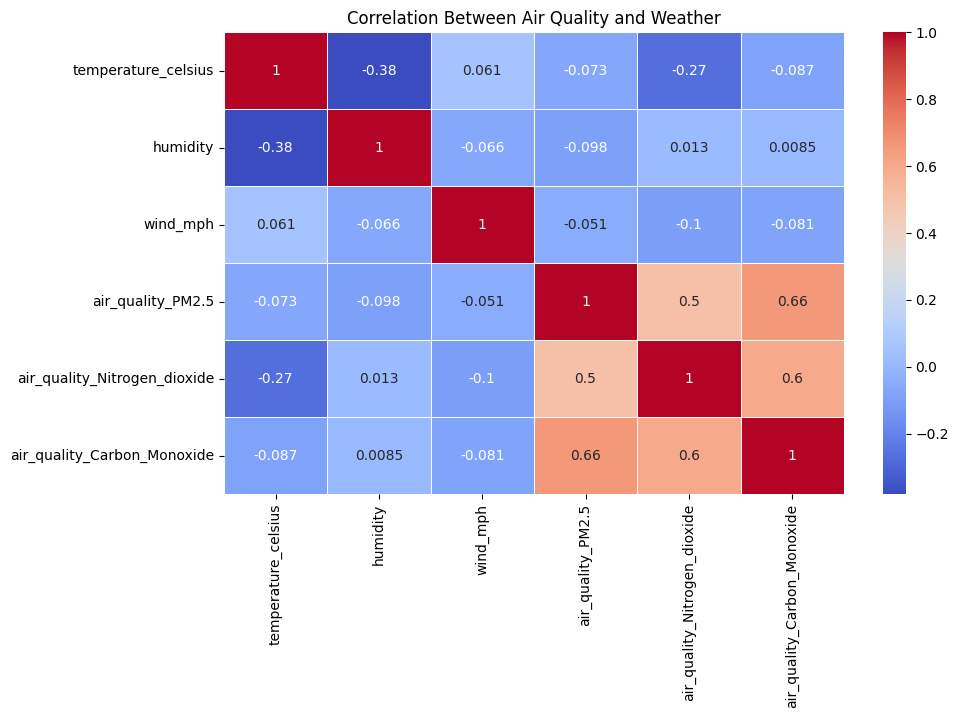

In [22]:
# Compute correlation matrix between air quality and weather parameters
weather_air_quality = data[["temperature_celsius", "humidity", "wind_mph", "air_quality_PM2.5", "air_quality_Nitrogen_dioxide", "air_quality_Carbon_Monoxide"]]

plt.figure(figsize=(10, 6))
sns.heatmap(weather_air_quality.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Air Quality and Weather")
plt.show()

Feature Importance

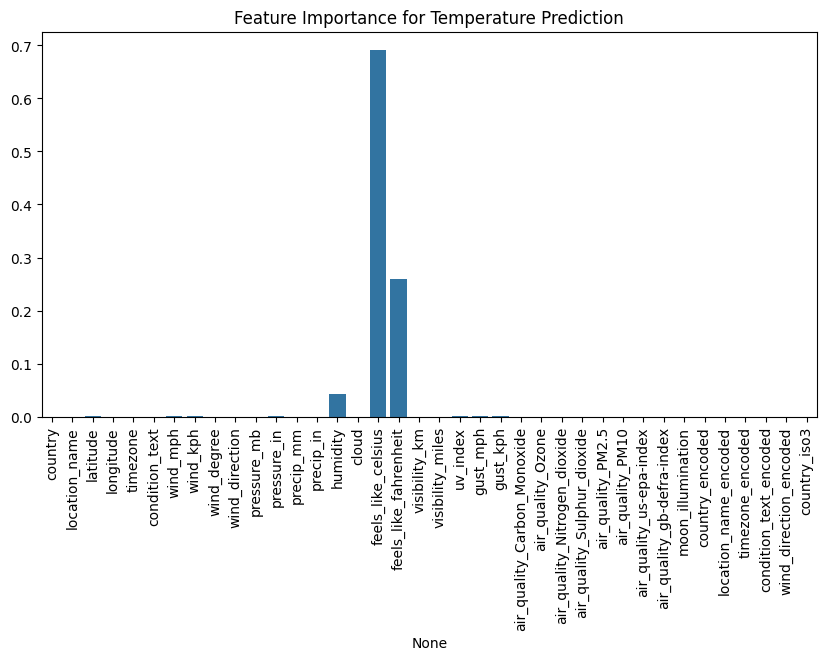

In [38]:
# Drop non-numeric columns or encode them
categorical_cols = ["country", "location_name", "timezone", "condition_text", "wind_direction"]
label_encoders = {}

for col in categorical_cols:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le  # Store encoders in case we need to reverse transform later

# Drop unnecessary columns
drop_cols = ["temperature_fahrenheit", "sunrise", "sunset", "moonrise", "moonset", "moon_phase"]
X = data.drop(["temperature_celsius"] + drop_cols, axis=1, errors="ignore")
y = data["temperature_celsius"]

# Train model
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=X.columns, y=importances)
plt.xticks(rotation=90)
plt.title("Feature Importance for Temperature Prediction")
plt.show()

Spatial Analysis & Geographical Patterns

<Figure size 1500x700 with 0 Axes>

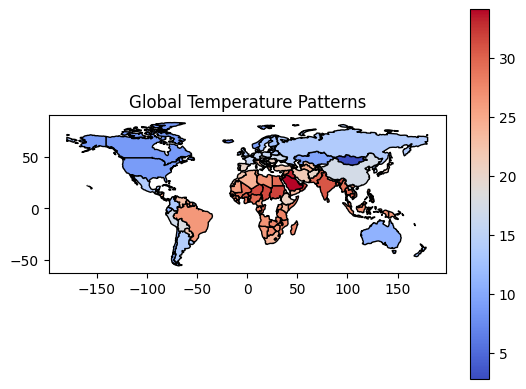

In [27]:
# Aggregate weather data by country
weather_by_country = data.groupby("country")[["temperature_celsius", "air_quality_PM2.5", "humidity"]].mean().reset_index()

# Merge with world map
world_weather = world.merge(weather_by_country, left_on="name", right_on="country")

# Plot spatial temperature patterns
plt.figure(figsize=(15,7))
world_weather.plot(column="temperature_celsius", cmap="coolwarm", legend=True, edgecolor="black")
plt.title("Global Temperature Patterns")
plt.show()